In [1]:
import numpy as np
import numpy.matlib
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
from PIL import Image
import matplotlib as mpl
from numba import njit
import time
import ipywidgets as ipw
from tqdm import tqdm


In [2]:
# Définition du nouvel angle
def theta_update(pos, angle, C, D_r, dt, N_birds):
    angle_new = np.zeros(N_birds)
    for i in range(N_birds):
        s = np.zeros(2)
        for j in range(N_birds):
            if (pos[0,i] - pos[0,j])**2 + (pos[1,i] - pos[1,j])**2 < R0**2:
                s[0] += np.cos(angle[j])
                s[1] += np.sin(angle[j])
        angle_new[i] = C*np.arctan2(s[0], s[1]) + (1-C)*(angle[i]+np.sqrt(2*D_r*dt)*np.random.normal(0,1))
    #print('theta_new :', theta_new[0], pos[0,0], pos[1,0])
    return angle_new

In [81]:
# Définition de la nouvelle position
def pos_update_old(pos, angle):
    sx = np.cos(angle)
    sy = np.sin(angle)
    return (pos[0,:] + v*dt*sx, pos[1,:] + v*dt*sy)

In [3]:
def pos_update(pos, angle):
    sx = np.cos(angle)
    sy = np.sin(angle)

    # Copie des positions pour éviter de modifier les positions d'origine
    new_pos = pos.copy()

    for i in range(N_birds):
        for j in range(N_birds):
            if i != j:  # Pour éviter de comparer un oiseau à lui-même
                distance = np.sqrt((pos[0, i] - pos[0, j])**2 + (pos[1, i] - pos[1, j])**2)
                if distance < R0:
                    diff = l0 - distance  # Différence par rapport à la distance désirée
                    direction = pos[:, j] - pos[:, i]  # Direction de l'ajustement
                    unit_direction = direction / distance  # Direction unitaire
                    adjustment = diff * unit_direction  # Ajustement de la position
                    new_pos[:, i] -= adjustment / 2  # Ajustement pour l'oiseau i
                    new_pos[:, j] += adjustment / 2  # Ajustement pour l'oiseau j

    # Mise à jour de la position en fonction de la vitesse et de la direction
    new_pos[0, :] += v * dt * sx
    new_pos[1, :] += v * dt * sy

    return new_pos

In [4]:
# Definition du paramètre d'ordre
def param_ordre(theta):
    a = np.zeros((N_birds,N_birds))
    for i in range(N_birds):
        for j in range(N_birds):
            a[i,j] = 2*(theta[i] - theta[j])
    return np.mean(np.cos([a]))

In [5]:
def plot_run(Nt, N_birds, L):
    plt.figure()
    for i in range(Nt-1):
        plt.clf()  # Pour effacer la figure précédente à chaque itération
        for Nb in range(N_birds-1):
            plt.arrow(Position[0,i,Nb], Position[1,i,Nb], np.cos(angle[i,Nb]), np.sin(angle[i, Nb]), width=0.05, head_width=0.5, color='blue')
            plt.title(f'Itération n°{i}')
        plt.arrow(Position[0,i,N_birds-1], Position[1,i,N_birds-1], np.cos(angle[i,N_birds-1]), np.sin(angle[i, N_birds-1]), width=0.05, head_width=0.5, color='tab:red')

        plt.xlim(-L, L)
        plt.ylim(-L, L) 
        plt.xlabel('temps '+ str(i))  
        plt.draw()  # Mettre à jour la figure
        plt.pause(0.01)  # Mettre une pause pour voir chaque image pendant 0.1 seconde
        clear_output(wait=True)  # Effacer la sortie de la cellule
    plt.close()

In [6]:
def plot_msd_po():
    # Calcul MSD
    msd = np.zeros(Nt)  
    for n in range(Nt):
        for i in range(0,Nt-n):
            msd[n] = msd[n] + (Position[0,i+n,0] - Position[0,i,0])**2
        msd[n] = msd[n]/(Nt-n)

    # Tracé du  MSD    
    print(msd[1])
    t = np.arange(Nt)*dt

    fig, ax = plt.subplots(1,2, figsize=(13,5))
    ax[0].loglog(t,msd)
    ax[0].set_title('Déplacement quadratique moyen (MSD) en fonction du temps')
    ax[0].set_xlabel('temps')
    ax[0].set_ylabel('Déplacement quadratique moyen')

    ax[1].plot(t[:-1], tab_param_ordre[:-1])
    ax[1].set_title("Paramètre d'ordre en fonction du temps")
    ax[1].set_xlabel('temps')
    ax[1].set_ylabel("paramètre d'ordre")
   
    plt.show()  

In [7]:
# MAIN
def main():

        # Définitions des tableaux et conditions initiales
        Position = np.zeros((2,Nt,N_birds))
        Position[0,0,:] = np.random.uniform(-L,L, N_birds)
        Position[1,0,:] = np.random.uniform(-L,L, N_birds)
        tab_param_ordre = np.zeros((Nt))
        angle = np.zeros((Nt, N_birds))
        theta =  np.sqrt(2*Dr*dt)*np.random.uniform(-np.pi, np.pi, N_birds) 

        for i in tqdm(range(Nt-1)):
                theta = theta_update(Position[:,i,:], theta, Coeff_couple, Dr, dt, N_birds)
                Position[:,i+1,:] = pos_update_old(Position[:,i,:], theta)

                # Conditions aux bords
                Position[0,i+1,:][Position[0,i+1,:] > L] -= 2*L
                Position[0,i+1,:][Position[0,i+1,:] <-L] += 2*L    
                Position[1,i+1,:][Position[1,i+1,:] > L] -= 2*L
                Position[1,i+1,:][Position[1,i+1,:] <-L] += 2*L
                
                angle[i,:] = theta
                
                tab_param_ordre[i] = param_ordre(angle[i,:])
        return Position, angle, tab_param_ordre

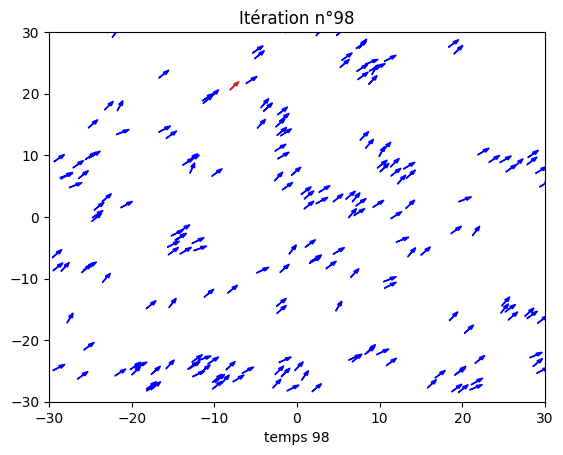

In [83]:
# Paramètres initiaux
Nt           = 100        # Nombre de frames
v            = 1          # Vitesse des oiseaux
dt           = 1          # Pas de temps
Dr           = 1          # Coefficient de diffusion
R0           = 3          # Rayon autour des oiseaux
L            = 30         # Dimensions de la boîte 
Coeff_couple = 0.9        # Coeficient de couplage
N_birds      = 200        # Nombre d'oiseaux
l0           = 3

if __name__ == '__main__':
    Position, angle, tab_param_ordre = main()
    plot_run(Nt, N_birds, L)

79.65525571264249


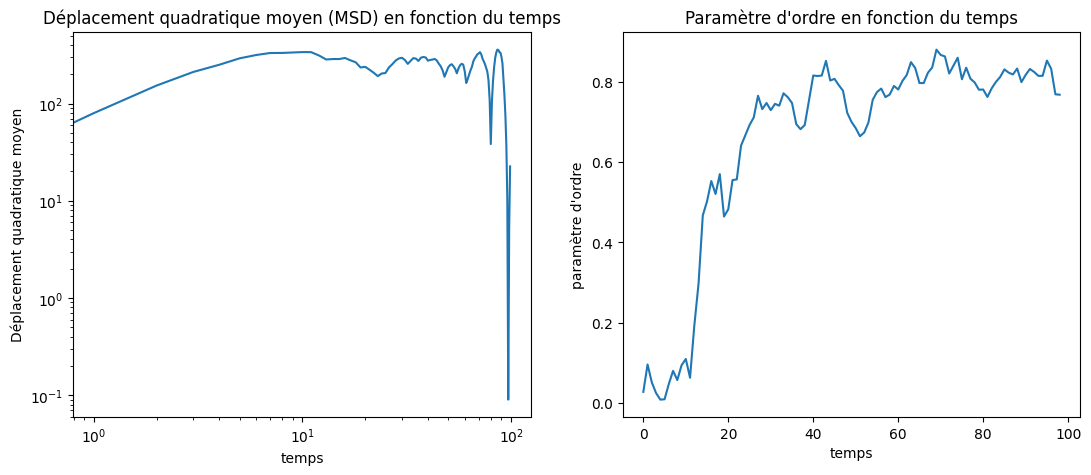

In [60]:
plot_msd_po()

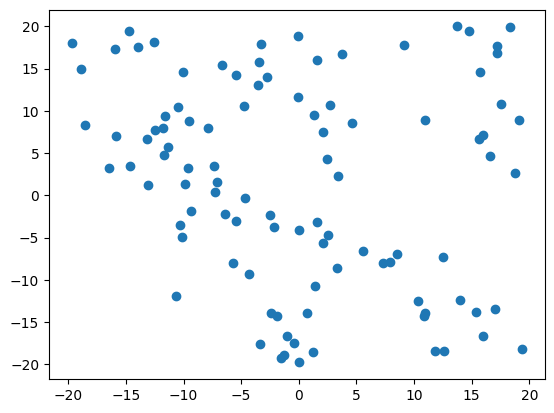

In [44]:
# Tracé des trajectoires des particules
plt.figure()
# for j in range(N_birds):
plt.scatter(Position[0,:-1,0],Position[1,:-1,0])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


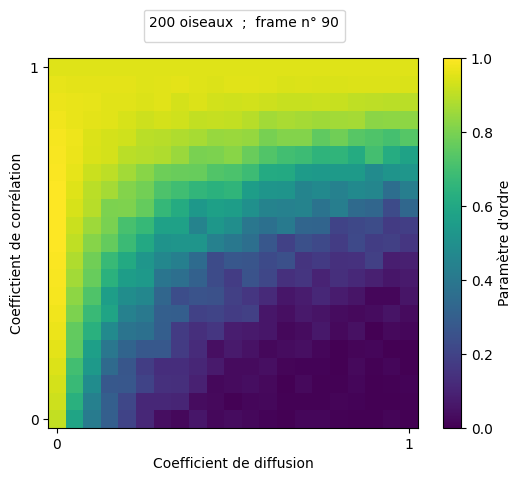

In [84]:
# Tracé du coefficient de corrélation en fonction du coefficient de diffusion 
# à l'aide du paramètre d'odre
pas = 20                                # Grille de pas*pas carreaux
tps = 90                                # Tracé au temps tps
N_c = np.linspace(0,1,pas +1)           # Discrétisation du coeff de corrélation
N_Dr = np.linspace(0,1,pas +1)          # Discrétisation du coeff de diffusion
phase_diagram = np.zeros((len(N_c),len(N_Dr)))

for nc in N_c:
    for ndr in N_Dr:
        p = param_ordre(theta_update(Position[:,tps,:], angle[tps,:], nc, ndr, dt, N_birds))
        phase_diagram[int(nc*pas), int(ndr*pas)] = p    
        
fig, ax = plt.subplots()
# Color bar
im = ax.imshow(phase_diagram, vmin=0, vmax=1) 
plt.colorbar(im, label="Paramètre d'ordre")

x_label_list = ['0', '1']
y_label_list = ['0', '1']
ax.set_xticks([0, 20])
ax.set_xticklabels(x_label_list)
ax.set_yticks([0, 20])
ax.set_yticklabels(y_label_list)
plt.xlabel('Coefficient de diffusion')
plt.ylabel('Coeffictient de corrélation')
plt.imshow(phase_diagram, origin='lower')
plt.legend(bbox_to_anchor=(0.53, 1.15), title = f'{N_birds} oiseaux  ;  frame n° {tps}', loc = 9, ncol = 2)